In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import torch
from greedy_models.mono_sign_glm import Mono_Sign_GLM

In [20]:
cos_basis_no = 22
cos_shift = 1.
cos_scale = 5.5
cos_basis = torch.zeros(cos_basis_no, 500)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793
            
    x_in = torch.arange(500)
    raw_cos = cos_scale * torch.log(x_in + cos_shift)
            
    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0 
    cos_basis[i] = cos_basis[i] + basis

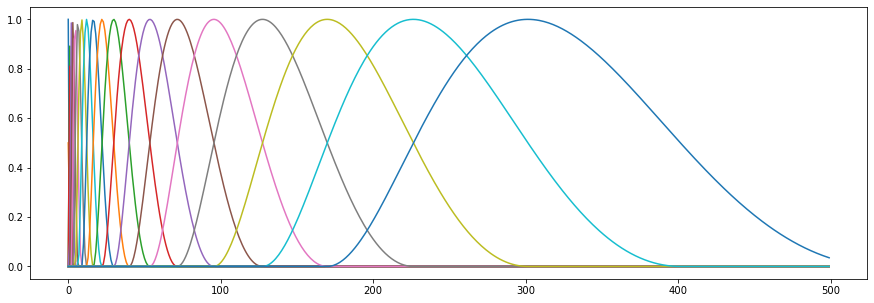

In [21]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(cos_basis[i].cpu().detach().numpy())

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
E_no = E_neural.shape[1]
I_no = I_neural.shape[1]
device = torch.device("cuda")

batch_size = 50000
iter_no = 9990
epoch_no = iter_no*batch_size//T_train 
print(epoch_no)

10


In [4]:
V_train = V[:T_train].to(device)
V_test = V[T_train:T_train + T_test].to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

In [5]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Mono_Sign_GLM(E_no, I_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

48403


In [ ]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    batch_pred, out_filters = model(batch_E_neural, batch_I_neural)
    loss = torch.var(batch_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        model.eval()
        test_V_pred, test_out_filters = model(test_E_neural, test_I_neural)
            
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        print(i, test_score)

<ipython-input-7-eff3c4aa0c40>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.16709288785618537
100 0.3151507949143849
200 0.4588048469549696
300 0.5643127487199644
400 0.6431819100759031
500 0.6989695428866902
600 0.7372910678073838
700 0.763003596239515
800 0.7794732333668458
900 0.7901869761844601
1000 0.7980329562907651
1100 0.8037808842452872
1200 0.808018898505722
1300 0.8118709615832662
1400 0.8150907586354998
1500 0.8174682482379497
1600 0.820772061315507
1700 0.823001511830807
1800 0.8255868979907995
1900 0.8271332231320017
2000 0.8290622191756224
2100 0.8308082829448803
2200 0.8326669490919252
2300 0.8344261769559482
2400 0.8362958987917173
2500 0.8380306011747212


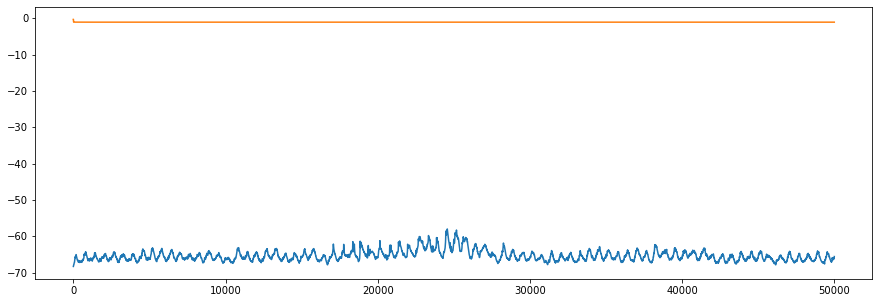

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [11]:
print(torch.exp(model.W_e))

tensor([[0.0181, 0.0181, 0.0182,  ..., 0.0183, 0.0183, 0.0183],
        [0.0175, 0.0175, 0.0175,  ..., 0.0183, 0.0183, 0.0183],
        [0.0177, 0.0177, 0.0177,  ..., 0.0183, 0.0183, 0.0183],
        ...,
        [0.0190, 0.0190, 0.0189,  ..., 0.0183, 0.0183, 0.0183],
        [0.0190, 0.0190, 0.0189,  ..., 0.0183, 0.0183, 0.0183],
        [0.0189, 0.0189, 0.0189,  ..., 0.0183, 0.0183, 0.0183]],
       device='cuda:0', grad_fn=<ExpBackward>)


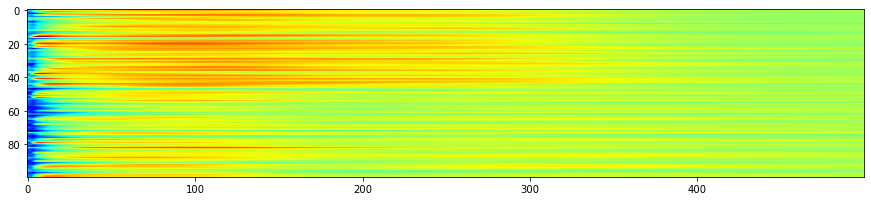

In [16]:
plt.figure(figsize = (15,15))
plt.imshow(test_out_filters.cpu().detach().numpy()[:100], cmap="jet")
#plt.colorbar()

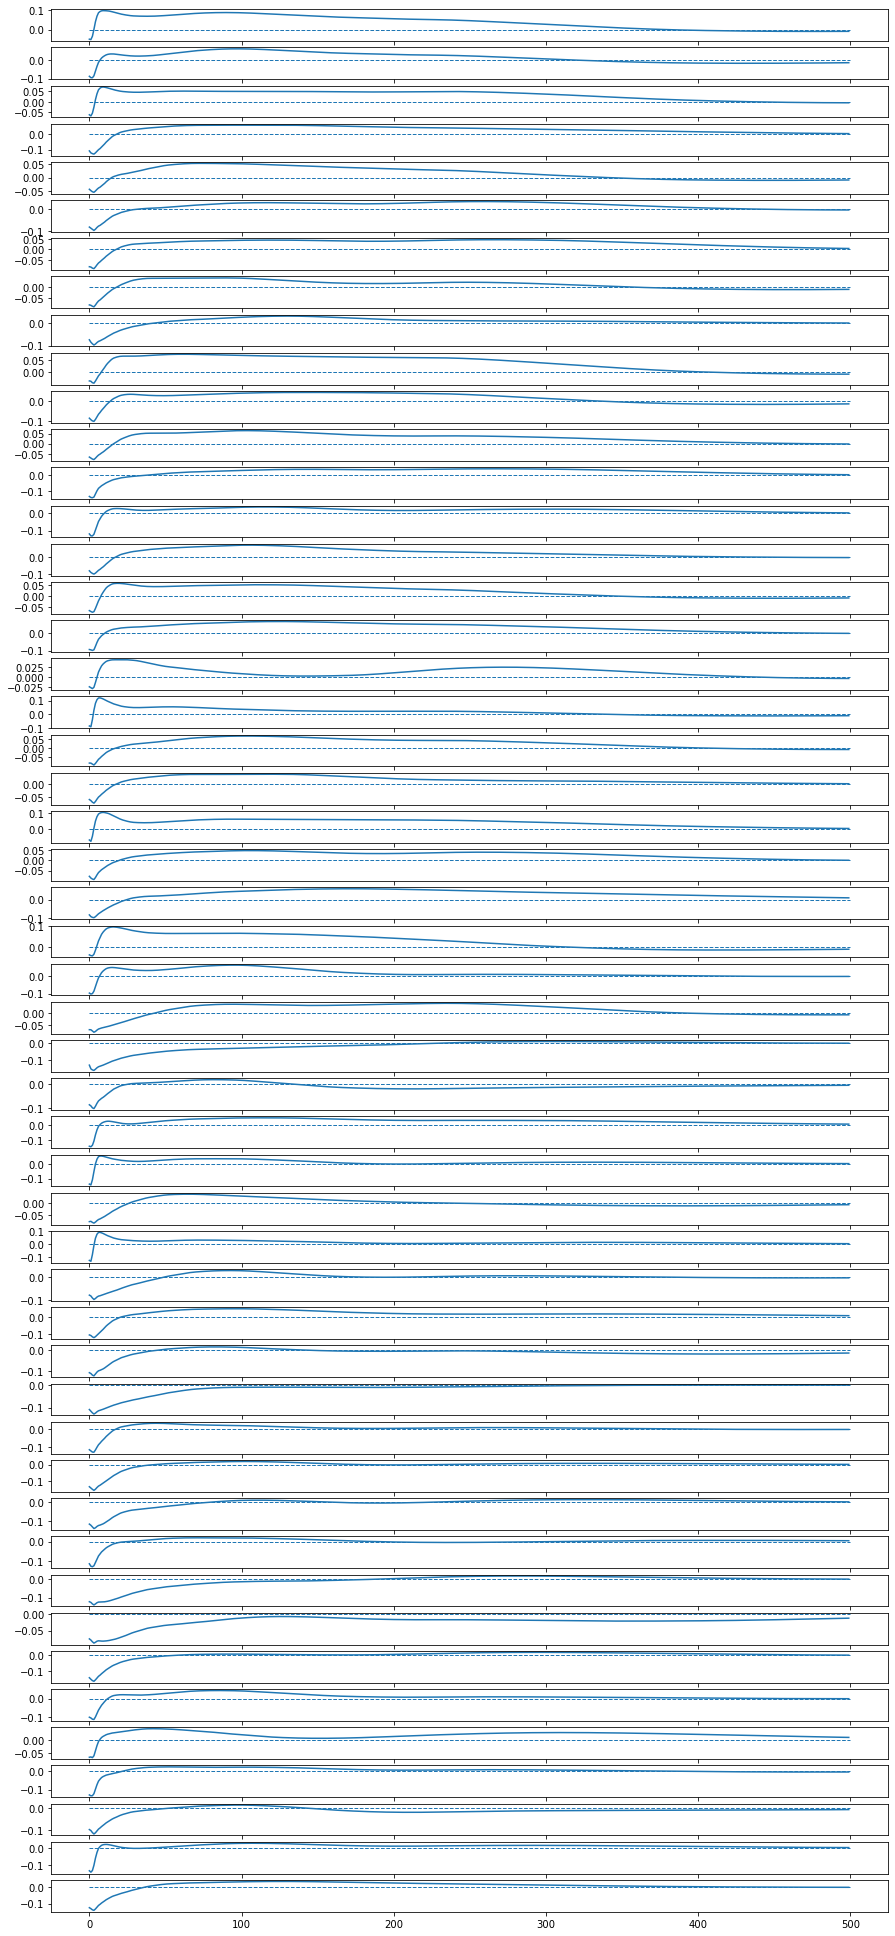

In [20]:
fig, axs = plt.subplots(nrows=50, figsize=(15,35))
for i in range(50):
    axs[i].plot(test_out_filters[i+20].cpu().detach().numpy())
    axs[i].hlines(y=0, xmin=0, xmax=500, linestyle="--", linewidth=1)